In [1]:
# visualization
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
fe = fm.FontEntry(
    fname=r'/usr/share/fonts/truetype/nanum/NanumGothic.ttf', # ttf 파일이 저장되어 있는 경로
    name='NanumBarunGothic')                        # 이 폰트의 원하는 이름 설정
fm.fontManager.ttflist.insert(0, fe)              # Matplotlib에 폰트 추가
plt.rcParams.update({'font.size': 10, 'font.family': 'NanumBarunGothic'}) # 폰트 설정
plt.rc('font', family='NanumBarunGothic')
import seaborn as sns

# utils
import pandas as pd
import numpy as np
from tqdm import tqdm
import pickle
import warnings;warnings.filterwarnings('ignore')
import gdown
import joblib

# Model
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
import lightgbm as lgb

import eli5
from eli5.sklearn import PermutationImportance

In [2]:
train_path = '../../data/train.csv'
test_path  = '../../data/test.csv'
dt = pd.read_csv(train_path)
dt_test = pd.read_csv(test_path)

# train/test 구분을 위한 칼럼을 하나 만들어 줍니다.
dt['is_test'] = 0
dt_test['is_test'] = 1
df = pd.concat([dt, dt_test])

# 필요 없어 보이는 columns 제거
drop_col = ['부번', '계약일', 'k-전화번호', 'k-팩스번호', 'k-관리방식', 'k-복도유형', 'k-시행사', 'k-사용검사일-사용승인일', 'k-홈페이지', 'k-등록일자', 'k-수정일자', '고용보험관리번호', '경비비관리형태', '세대전기계약방법', '청소비관리형태', '기타/의무/임대/임의=1/2/3/4', '단지승인일', '사용허가여부', '관리비 업로드', '단지신청일', 'k-관리비부과면적', '주차대수', '건축면적', '해제사유발생일', '단지소개기존clob', 'k-135㎡초과', '중개사소재지', '등기신청일자', '거래유형']
df.drop(drop_col, axis=1, inplace=True)

# 동, 구 분류
df['구'] = df['시군구'].apply(lambda x:x.split()[1])
df['동'] = df['시군구'].apply(lambda x:x.split()[2])
omg = ['용산구', '강남구', '서초구', '송파구', '성동구', '종로구']
is_omg = []
for x in df['구'].tolist():
    if x in omg:
        is_omg.append(1)
    else:
        is_omg.append(0)
df['개비싸'] = is_omg
# 이렇게 말고 '동' 을 분류하지 않아도 될듯       
df.loc[~df['구'].isin(omg), '동'] = 'Unknown' 
del df['시군구']

# 본번, 부번의 경우 float로 되어있지만 범주형 변수의 의미를 가지므로 object(string) 형태로 바꾸어주고 아래 작업을 진행하겠습니다.
df['본번'] = df['본번'].astype('str')

df['계약년월'] = df['계약년월'].astype(str)
df['계약년'] = df['계약년월'].map(lambda x : x[:4])
# df['계약월'] = df['계약년월'].map(lambda x : x[4:])
# df['계약년월'] = pd.to_datetime(df['계약년월'], format='%Y%m')

# 수치형 데이터를 어떻게 채워야 될지 모르겠음 -> 걍 빼.
# 좌표X, 좌표Y 를 리니어로 채우는건 혼동을 줄 수 있는 데이터임
df.drop(columns=['k-전체동수', 'k-전체세대수', 'k-연면적', 'k-주거전용면적', 'k-전용면적별세대현황(60㎡이하)', 'k-전용면적별세대현황(60㎡~85㎡이하)', 'k-85㎡~135㎡이하', '좌표X', '좌표Y'], inplace=True)


continuous_columns = []
categorical_columns = []

for column in df.columns:
    if pd.api.types.is_numeric_dtype(df[column]):
        continuous_columns.append(column)
    else:
        categorical_columns.append(column)
df[categorical_columns] = df[categorical_columns].fillna('NULL')

In [3]:
df_train = df.loc[df['is_test']==0, :]
df_test = df.loc[df['is_test']==1, :]

df_train.drop(['is_test'], axis=1, inplace=True)
df_test.drop(['is_test'], axis=1, inplace=True)
print(df_train.shape, df_test.shape)

(1118822, 17) (9272, 17)


In [4]:
# 파생변수 제작으로 추가된 변수들이 존재하기에, 다시한번 연속형과 범주형 칼럼을 분리해주겠습니다.
continuous_columns_v2 = []
categorical_columns_v2 = []

for column in df_train.columns:
    if pd.api.types.is_numeric_dtype(df_train[column]):
        continuous_columns_v2.append(column)
    else:
        categorical_columns_v2.append(column)

# 아래에서 범주형 변수들을 대상으로 레이블인코딩을 진행해 주겠습니다.

# 각 변수에 대한 LabelEncoder를 저장할 딕셔너리
label_encoders = {}

# Implement Label Encoding
for col in tqdm( categorical_columns_v2 ):
    lbl = LabelEncoder()

    # Label-Encoding을 fit
    lbl.fit( df_train[col].astype(str) )
    df_train[col] = lbl.transform(df_train[col].astype(str))
    label_encoders[col] = lbl           # 나중에 후처리를 위해 레이블인코더를 저장해주겠습니다.

    # Test 데이터에만 존재하는 새로 출현한 데이터를 신규 클래스로 추가해줍니다.
    for label in np.unique(df_test[col]):
      if label not in lbl.classes_: # unseen label 데이터인 경우
        lbl.classes_ = np.append(lbl.classes_, label) # 미처리 시 ValueError발생하니 주의하세요!

    df_test[col] = lbl.transform(df_test[col].astype(str))


def preprocess_feature_name(feature_name):
  """특수 문자를 제거하고 소문자로 변환합니다."""
  feature_name = feature_name.replace("-", "_")
  feature_name = feature_name.replace(",", "_")
  feature_name = feature_name.replace(".", "_")
  feature_name = feature_name.replace("(", "_")
  feature_name = feature_name.replace(")", "_")
  feature_name = feature_name.lower()
  return feature_name

def apply_preprocessed_feature_names(df_train):
  """데이터 프레임의 feature 이름을 수정합니다."""
  df_train.columns = [preprocess_feature_name(feature) for feature in df_train.columns]
  return df_train

# 데이터 프레임에 적용
df_train = apply_preprocessed_feature_names(df_train.copy())
df_test = apply_preprocessed_feature_names(df_test.copy())



100%|██████████| 12/12 [00:03<00:00,  3.92it/s]


In [5]:
print(df_train.shape)
display(df_train.head())

(1118822, 17)


,번지,본번,아파트명,전용면적_㎡_,계약년월,층,건축년도,도로명,k_단지분류_아파트_주상복합등등_,k_세대타입_분양형태_,k_난방방식,k_건설사_시공사_,target,구,동,개비싸,계약년
0,4732,1149,328,79.97,131,3,1987,6176,3,2,1,241,124000.0,0,3,1,10
1,4732,1149,328,79.97,131,4,1987,6176,3,2,1,241,123500.0,0,3,1,10
2,4732,1149,328,54.98,131,5,1987,6176,3,2,1,241,91500.0,0,3,1,10
3,4732,1149,328,79.97,132,4,1987,6176,3,2,1,241,130000.0,0,3,1,11
4,4732,1149,328,79.97,132,2,1987,6176,3,2,1,241,117000.0,0,3,1,11


In [6]:
train_labels = df_train['target'].reset_index(drop=True)
train_features = df_train.drop(['target'], axis=1)

In [7]:
# Models
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, BaggingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.linear_model import ElasticNet, ElasticNetCV
from sklearn.svm import SVR
from mlxtend.regressor import StackingCVRegressor
import lightgbm as lgb
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

from sklearn.model_selection import KFold, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler

In [8]:
# Setup cross validation folds
kf = KFold(n_splits=3, random_state=42, shuffle=True)

In [9]:
def cv_rmse(model, X=train_features):
    rmse = np.sqrt(-cross_val_score(model, X, train_labels, scoring="neg_mean_squared_error", cv=kf))
    return (rmse)

In [10]:
# Light Gradient Boosting Regressor
lightgbm = LGBMRegressor(objective='regression', 
                       num_leaves=6,
                       learning_rate=0.01, 
                       n_estimators=1000,
                       max_bin=200, 
                       bagging_fraction=0.8,
                       bagging_freq=4, 
                       bagging_seed=8,
                       feature_fraction=0.2,
                       feature_fraction_seed=8,
                       min_sum_hessian_in_leaf = 11,
                       verbose=-1,
                       random_state=42)

# XGBoost Regressor
xgboost = XGBRegressor(learning_rate=0.01,
                       n_estimators=1000,
                       max_depth=4,
                       min_child_weight=0,
                       gamma=0.6,
                       subsample=0.7,
                       colsample_bytree=0.7,
                       objective='reg:linear',
                       nthread=-1,
                       scale_pos_weight=1,
                       seed=27,
                       reg_alpha=0.00006,
                       random_state=42)

# # Ridge Regressor
# ridge_alphas = [1e-15, 1e-10, 1e-8, 9e-4, 7e-4, 5e-4, 3e-4, 1e-4, 1e-3, 5e-2, 1e-2, 0.1, 0.3, 1, 3, 5, 10, 15, 18, 20, 30, 50, 75, 100]
# ridge = make_pipeline(RobustScaler(), RidgeCV(alphas=ridge_alphas, cv=kf))

# # Support Vector Regressor
# svr = make_pipeline(RobustScaler(), SVR(C= 5, epsilon= 0.008, gamma=0.0003))

# Gradient Boosting Regressor
# gbr = GradientBoostingRegressor(n_estimators=200,
#                                 learning_rate=0.01,
#                                 max_depth=4,
#                                 max_features='sqrt',
#                                 min_samples_leaf=15,
#                                 min_samples_split=10,
#                                 loss='huber',
#                                 random_state=42)  

# Random Forest Regressor
# rf = RandomForestRegressor(n_estimators=300,
#                           max_depth=15,
#                           min_samples_split=5,
#                           min_samples_leaf=5,
#                           max_features=None,
#                           oob_score=True,
#                           random_state=42)

# Stack up all the models above, optimized using xgboost
stack_gen = StackingCVRegressor(regressors=(xgboost, lightgbm),
                                meta_regressor=xgboost,
                                use_features_in_secondary=True)

In [11]:
scores = {}

score = cv_rmse(lightgbm)
print("lightgbm: {:.4f} ({:.4f})".format(score.mean(), score.std()))
scores['lgb'] = (score.mean(), score.std())

lightgbm: 20214.1157 (259.3748)


In [12]:
score = cv_rmse(xgboost)
print("xgboost: {:.4f} ({:.4f})".format(score.mean(), score.std()))
scores['xgb'] = (score.mean(), score.std())

xgboost: 15848.4345 (128.9781)


In [13]:
# score = cv_rmse(svr)
# print("SVR: {:.4f} ({:.4f})".format(score.mean(), score.std()))
# scores['svr'] = (score.mean(), score.std())

In [14]:
# score = cv_rmse(ridge)
# print("ridge: {:.4f} ({:.4f})".format(score.mean(), score.std()))
# scores['ridge'] = (score.mean(), score.std())

In [15]:
# score = cv_rmse(rf)
# print("rf: {:.4f} ({:.4f})".format(score.mean(), score.std()))
# scores['rf'] = (score.mean(), score.std())

In [16]:
# score = cv_rmse(gbr)
# print("gbr: {:.4f} ({:.4f})".format(score.mean(), score.std()))
# scores['gbr'] = (score.mean(), score.std())

In [17]:
print('stack_gen')
stack_gen_model = stack_gen.fit(np.array(train_features), np.array(train_labels))

stack_gen


In [18]:
print('lightgbm')
lgb_model_full_data = lightgbm.fit(train_features, train_labels)

lightgbm


In [19]:
print('xgboost')
xgb_model_full_data = xgboost.fit(train_features, train_labels)

xgboost


In [20]:
def blended_predictions(X):
    return (
            # (0.1 * ridge_model_full_data.predict(X)) + \
            # (0.2 * svr_model_full_data.predict(X)) + \
            # (0.1 * gbr_model_full_data.predict(X)) + \
            (0.25 * xgb_model_full_data.predict(X)) + \
            (0.25 * lgb_model_full_data.predict(X)) + \
            # (0.05 * rf_model_full_data.predict(X)) + \
            (0.5 * stack_gen_model.predict(np.array(X))))

In [22]:
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

# Get final precitions from the blended model
blended_score = rmsle(train_labels, blended_predictions(train_features))
scores['blended'] = (blended_score, 0)
print('RMSLE score on train data:')
print(blended_score)

RMSLE score on train data:
15509.416053449619


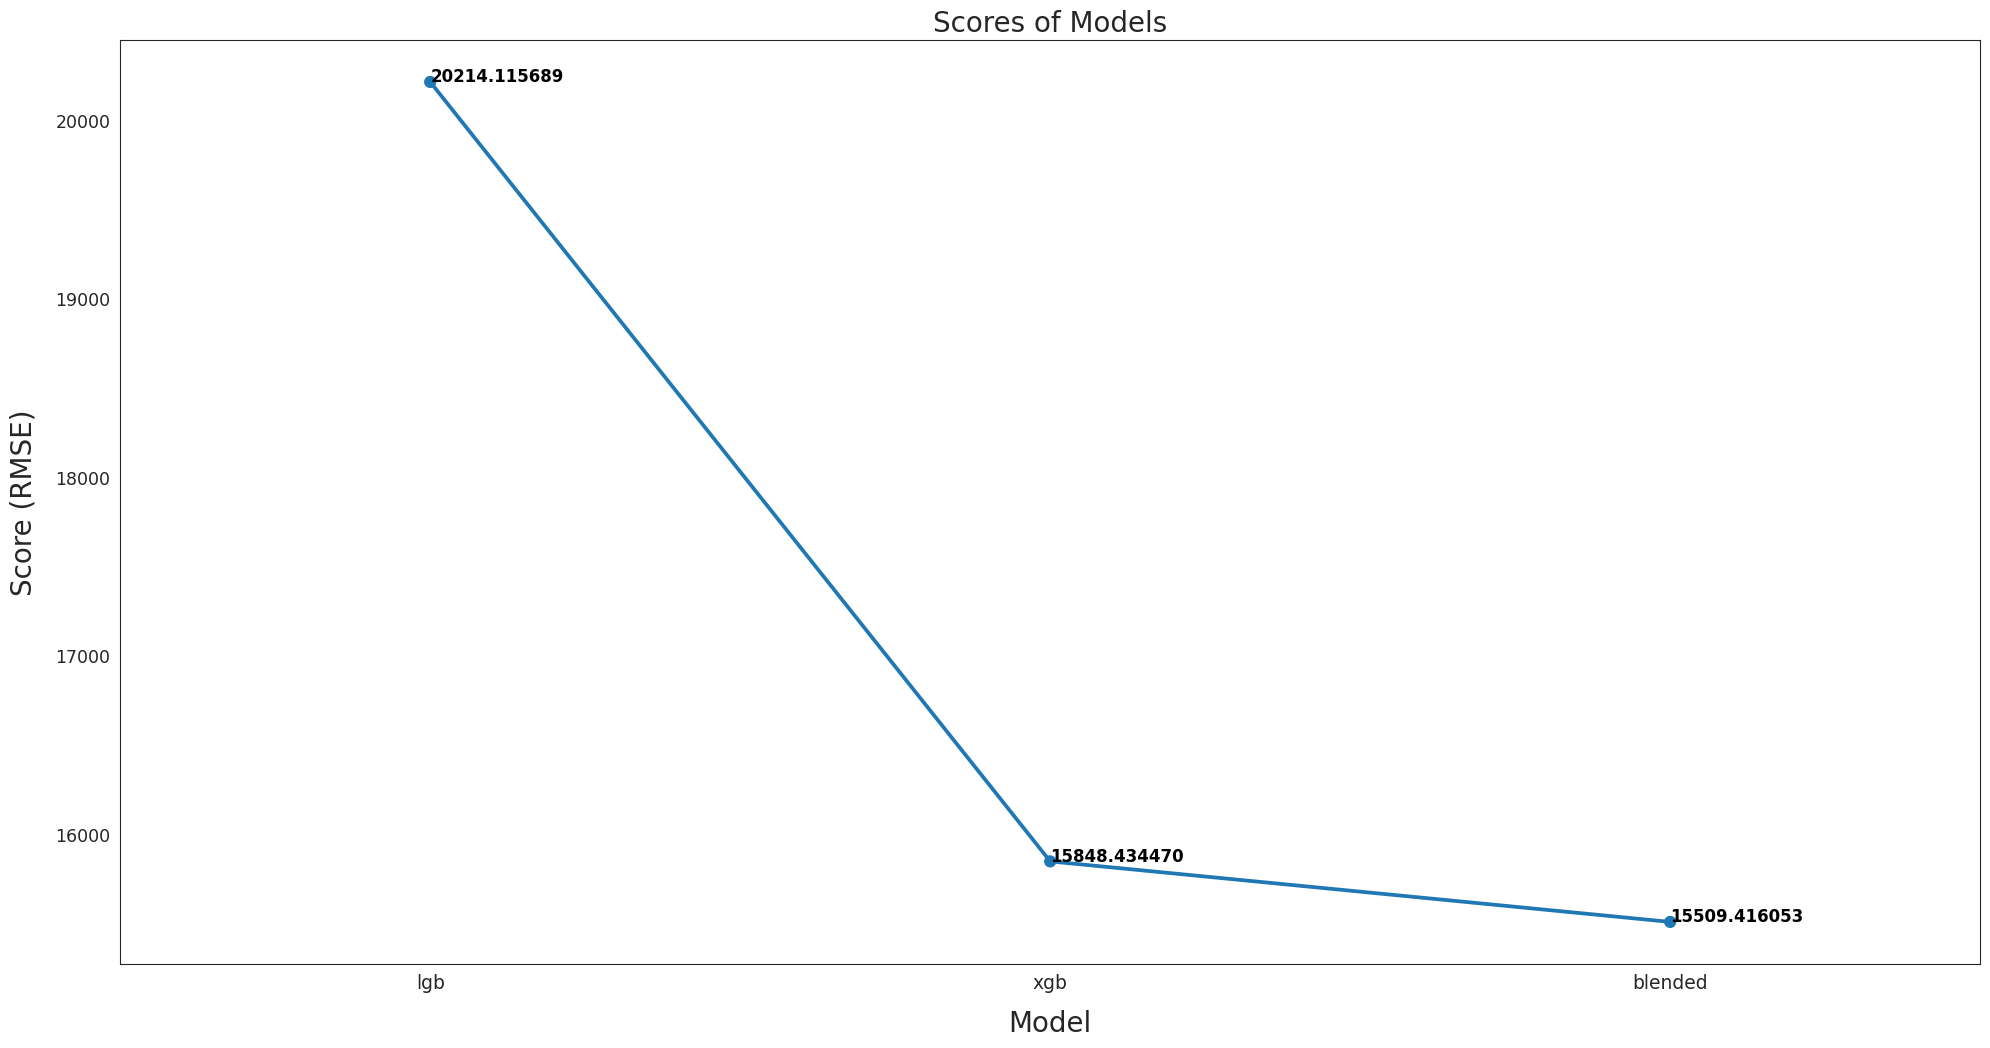

In [23]:
# Plot the predictions for each model
sns.set_style("white")
fig = plt.figure(figsize=(24, 12))

ax = sns.pointplot(x=list(scores.keys()), y=[score for score, _ in scores.values()], markers=['o'], linestyles=['-'])
for i, score in enumerate(scores.values()):
    ax.text(i, score[0] + 0.002, '{:.6f}'.format(score[0]), horizontalalignment='left', size='large', color='black', weight='semibold')

plt.ylabel('Score (RMSE)', size=20, labelpad=12.5)
plt.xlabel('Model', size=20, labelpad=12.5)
plt.tick_params(axis='x', labelsize=13.5)
plt.tick_params(axis='y', labelsize=12.5)

plt.title('Scores of Models', size=20)

plt.show()